Introduction

- As a graduated master student in Sweden, I've chosen to analyze data from IKEA, one of the world's largest Swedish furniture companies. IKEA is renowned not only for its affordable and stylish furniture but also for its commitment to innovation and the application of AI/ML in various aspects of its operations. This project aims to explore IKEA's product data, focusing on pricing strategies, product categories, and potential discounts.

# 1. Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
import pickle

# 2. Data

In [ ]:
df = pd.read_csv('IKEA_SA_Furniture_Web_Scrapings_sss.csv')
df = df.drop(df.columns[0], axis=1)

In [ ]:
#Display the first few rows
df.head()

,ID,Name,Category,Price,Old Price,Sellable Online,Link,Other Colors,Description,Designer,Depth,Height,Width
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


In [ ]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               3694 non-null   int64  
 1   Name             3694 non-null   object 
 2   Category         3694 non-null   object 
 3   Price            3694 non-null   float64
 4   Old Price        3694 non-null   object 
 5   Sellable Online  3694 non-null   bool   
 6   Link             3694 non-null   object 
 7   Other Colors     3694 non-null   object 
 8   Description      3694 non-null   object 
 9   Designer         3694 non-null   object 
 10  Depth            2231 non-null   float64
 11  Height           2706 non-null   float64
 12  Width            3105 non-null   float64
dtypes: bool(1), float64(4), int64(1), object(7)
memory usage: 350.0+ KB


# 3. Exploratory Data Analysis

### 3.1 Data Visualization

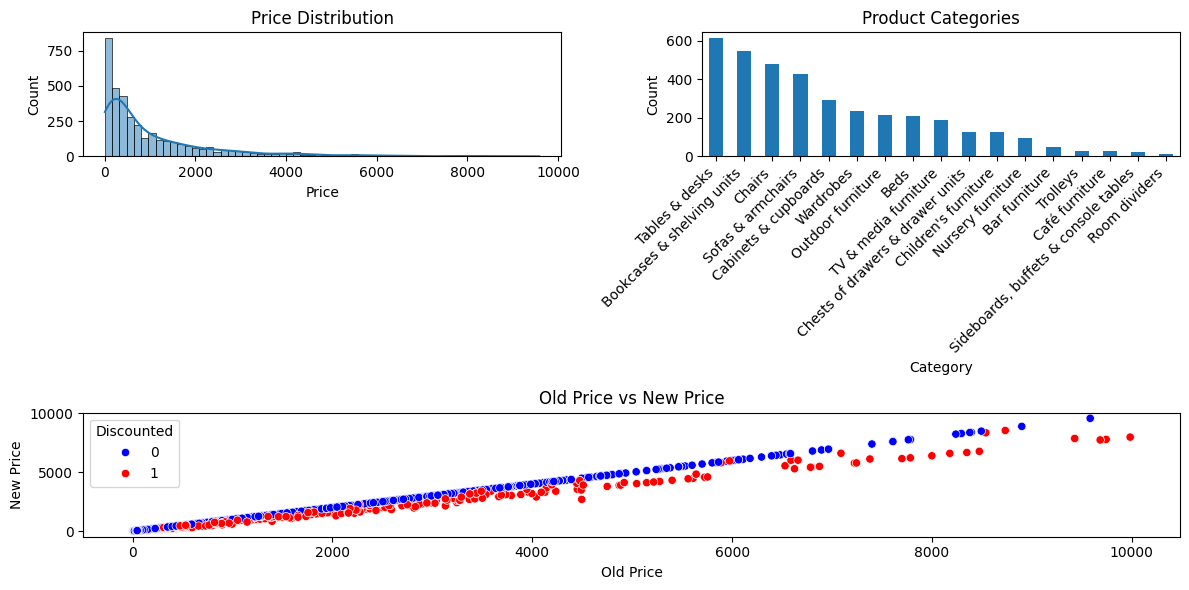

Number of discounted items: 644
Percentage of discounted items: 17.43%


In [ ]:
# Function to clean price strings and convert in float value
def clean_price(price):
    if pd.isna(price) or price == 'No old price':
        return np.nan
    price = str(price).replace('SR ', '').replace(',', '')
    try:
        return float(price)
    except ValueError:
        return np.nan

# Clean 'Old Price' column. Apply the clean_price function to each value in the 'Old Price' column of the df
df['Old Price'] = df['Old Price'].apply(clean_price)

# Update Old Price
df['Old Price'] = df['Old Price'].fillna(df['Price'])

# Update Discounted feature.
#Create a new column 'Discounted' which is 1 if 'Old Price' is greater than 'Price'and 0 otherwise
df['Discounted'] = np.where(df['Old Price'] > df['Price'], 1, 0)


# Visualizations
plt.figure(figsize=(12, 6))

# Price distribution histogram
plt.subplot(2, 2, 1)
sns.histplot(df['Price'], kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')

# Category distribution bar plot
plt.subplot(2, 2, 2)
df['Category'].value_counts().plot(kind='bar')
plt.title('Product Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Scatter plot: Old Price vs New Price
plt.subplot(2, 2, (3, 4))
sns.scatterplot(data=df[df['Old Price'].notnull()], x='Old Price', y='Price', hue='Discounted', palette={0: 'blue', 1: 'red'})
plt.title('Old Price vs New Price')
plt.xlabel('Old Price')
plt.ylabel('New Price')

plt.tight_layout()
plt.show()

# Print summary of discounted items
print(f"Number of discounted items: {df['Discounted'].sum()}")
print(f"Percentage of discounted items: {df['Discounted'].mean()*100:.2f}%")

### 3.2 Feature Engineering Steps

This code performs the following feature engineering steps:

- Converts 'Sellable Online' to numeric.
- Ensures 'Depth', 'Height', and 'Width' are numeric.
- Creates a 'Volume' feature.
- Creates a 'Price per Volume' feature.
- Creates dummy variables for 'Category'.
- Creates a 'Has Other Colors' feature.
- Creates a 'Description Word Count' feature.

In [ ]:
# Convert 'Sellable Online' to numeric
df['Sellable Online'] = df['Sellable Online'].astype(int)

# Extract numerical values from 'Depth', 'Height', and 'Width'
for col in ['Depth', 'Height', 'Width']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create a 'Volume' feature
df['Volume'] = df['Depth'] * df['Height'] * df['Width']

# Create a 'Price per Volume' feature
df['Price per Volume'] = df['Price'] / df['Volume']

# Create dummy variables for 'Category', where each category gets its own column with binary values.
category_dummies = pd.get_dummies(df['Category'], prefix='Category')
df = pd.concat([df, category_dummies], axis=1)

# Create a 'Has Other Colors' feature   // other color=1  no other color=0
df['Has Other Colors'] = np.where(df['Other Colors'] != 'No', 1, 0)

# Create a 'Word Count' feature for the description
df['Description Word Count'] = df['Description'].str.split().str.len()

# Print the new features
print(df[['Volume', 'Price per Volume', 'Has Other Colors', 'Description Word Count']].head())

     Volume  Price per Volume  Has Other Colors  Description Word Count
0       NaN               NaN                 0                       5
1       NaN               NaN                 0                       4
2       NaN               NaN                 0                       6
3  300000.0          0.000230                 1                       6
4  190920.0          0.001179                 0                       5


In [ ]:
# Investigate Missing Values
print(df[['Depth', 'Height', 'Width']].isnull().sum())

Depth     1463
Height     988
Width      589
dtype: int64


In [ ]:
# Imputation strategies: For numerical columns like these, we could impute missing values with the median of each category
for dim in ['Depth', 'Height', 'Width']:
    df[dim] = df.groupby('Category')[dim].transform(lambda x: x.fillna(x.median()))

In [ ]:
# Recalculate Volume
df['Volume'] = df['Depth'] * df['Height'] * df['Width']
df['Price per Volume'] = df['Price'] / df['Volume']

In [ ]:
df.head()

,ID,Name,Category,Price,Old Price,Sellable Online,Link,Other Colors,Description,Designer,...,Category_Outdoor furniture,Category_Room dividers,"Category_Sideboards, buffets & console tables",Category_Sofas & armchairs,Category_TV & media furniture,Category_Tables & desks,Category_Trolleys,Category_Wardrobes,Has Other Colors,Description Word Count
0,90420332,FREKVENS,Bar furniture,265.0,265.0,1,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,...,False,False,False,False,False,False,False,False,0,5
1,368814,NORDVIKEN,Bar furniture,995.0,995.0,0,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,...,False,False,False,False,False,False,False,False,0,4
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,2095.0,0,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,...,False,False,False,False,False,False,False,False,0,6
3,80155205,STIG,Bar furniture,69.0,69.0,1,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,...,False,False,False,False,False,False,False,False,1,6
4,30180504,NORBERG,Bar furniture,225.0,225.0,1,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,...,False,False,False,False,False,False,False,False,0,5


### 3.3 Categorical Variable Visualization

In [ ]:
import plotly.graph_objects as go
import pandas as pd

def create_donut_plot(data, column, title):
    counts = data[column].value_counts()
    total = counts.sum()

    labels = ['Yes' if val == 1 else 'No' for val in counts.index]
    values = counts.values

    fig = go.Figure(data=[go.Pie(
        labels=labels,
        values=values,
        hole=.6,
        marker_colors=['#636EFA', '#EF553B'],
        textinfo='percent',
        hoverinfo='label+value',
        textfont_size=14
    )])

    fig.update_layout(
        title={
            'text': title,
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=24)
        },
        annotations=[dict(text=f'Number of Samples<br>{total}', x=0.5, y=0.5, font_size=16, showarrow=False)],
        showlegend=True,
        legend=dict(orientation="h", yanchor="bottom", y=-0.1, xanchor="center", x=0.5),
        width=800,
        height=500
    )

    fig.show()

# Create donut plots
create_donut_plot(df, 'Sellable Online', 'Products Sellable Online')
create_donut_plot(df, 'Discounted', 'Discounted Products')
create_donut_plot(df, 'Has Other Colors', 'Products with Other Color Options')

# 4. Machine Learning Model

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ID                                             3694 non-null   int64  
 1   Name                                           3694 non-null   object 
 2   Category                                       3694 non-null   object 
 3   Price                                          3694 non-null   float64
 4   Old Price                                      3694 non-null   float64
 5   Sellable Online                                3694 non-null   int64  
 6   Link                                           3694 non-null   object 
 7   Other Colors                                   3694 non-null   object 
 8   Description                                    3694 non-null   object 
 9   Designer                                       3694 

Selected features: ['Price', 'Volume', 'Price per Volume', 'Description Word Count']

Best parameters for RandomForest:
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 score: 0.4003

Best parameters for XGBoost:
{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200}
Best F1 score: 0.4298

Best parameters for GradientBoosting:
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200}
Best F1 score: 0.4666

Best model: GradientBoosting
Model and preprocessing objects saved.

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       604
           1       0.62      0.41      0.49       135

    accuracy                           0.85       739
   macro avg       0.75      0.68      0.70       739
weighted avg       0.83      0.85      0.83       739



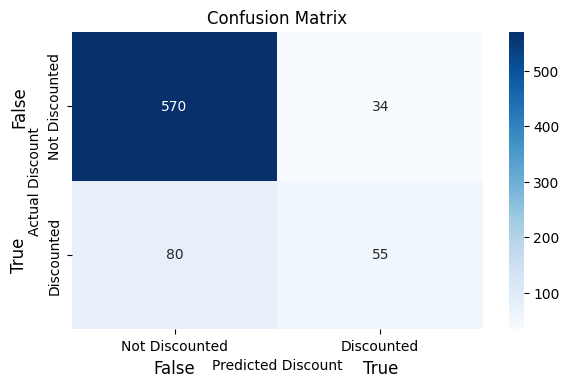

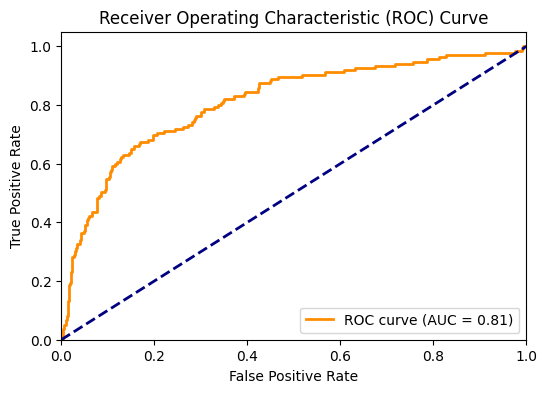

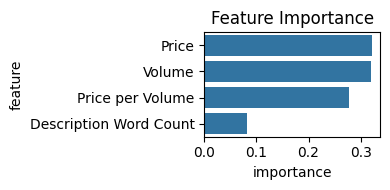

In [ ]:
# Select initial features
features = ['Price', 'Volume', 'Price per Volume', 'Sellable Online', 'Has Other Colors',
            'Description Word Count'] + [col for col in df.columns if col.startswith('Category_')]
# This selects specific features and any column that starts with 'Category_'

X = df[features]  # Feature matrix
y = df['Discounted']  # Target variable

# Split the data into training (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Random state ensures reproducibility

# Scale the features to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Scaling is important for many machine learning algorithms

# Feature selection using Random Forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
selector = SelectFromModel(rf_selector, prefit=False)
selector.fit(X_train_scaled, y_train)
selected_feat_bool = selector.get_support()
selected_features = X.columns[selected_feat_bool].tolist()
# This step selects the most important features, which can improve model performance

print("Selected features:", selected_features)

X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

#Define 3 models (RandomForest, XGBoost, GradientBoosting) and their hyperparameters for tuning
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3]
    }
}

# Train and tune models using GridSearchCV
# We store the best model and its F1 score for each algorithm.
best_models = {}
best_scores = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, n_jobs=-1, scoring='f1')
    # 5-fold cross-validation, use all available cores, optimize for F1 score
    grid_search.fit(X_train_selected, y_train)
    best_models[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_
    print(f"\nBest parameters for {name}:")
    print(grid_search.best_params_)
    print(f"Best F1 score: {grid_search.best_score_:.4f}")

# Select the best model based on F1 highest score
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
print(f"\nBest model: {best_model_name}")

# Save the best model, scaler, feature selector, and original features for later use
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('feature_selector.pkl', 'wb') as f:
    pickle.dump(selector, f)

with open('original_features.pkl', 'wb') as f:
    pickle.dump(features, f)

print("Model and preprocessing objects saved.")

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create and display a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Discounted', 'Discounted'],
            yticklabels=['Not Discounted', 'Discounted'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Discount')
plt.ylabel('Actual Discount')

# Add text annotations for True/False
plt.text(-0.3, 0.5, 'False', rotation=90, verticalalignment='center', fontsize=12)
plt.text(-0.3, 1.5, 'True', rotation=90, verticalalignment='center', fontsize=12)
plt.text(0.5, 2.3, 'False', horizontalalignment='center', fontsize=12)
plt.text(1.5, 2.3, 'True', horizontalalignment='center', fontsize=12)

plt.tight_layout()
plt.show()

# Create and display ROC curve, that shows the performance of a model
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display feature importance if available
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(4, 2))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance not available for this model.")

# 5. Predict New Sample

In [ ]:
def load_model_and_preprocessors():
    with open('best_model.pkl', 'rb') as f:
        model = pickle.load(f)
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    with open('feature_selector.pkl', 'rb') as f:
        selector = pickle.load(f)
    with open('original_features.pkl', 'rb') as f:
        original_features = pickle.load(f)
    return model, scaler, selector, original_features

def prepare_input(data, original_features):
    # Create a DataFrame with the input data
    input_df = pd.DataFrame([data])

    # Ensure all original features are present, fill missing ones with 0
    for feature in original_features:
        if feature not in input_df.columns:
            input_df[feature] = 0

    # Reorder columns to match original features
    input_df = input_df[original_features]

    # Ensure boolean features are correct type
    bool_features = ['Sellable Online', 'Has Other Colors'] + [col for col in input_df.columns if col.startswith('Category_')]
    for feature in bool_features:
        if feature in input_df.columns:
            input_df[feature] = input_df[feature].astype(int)

    return input_df

def predict_discount(input_dict):
    # Load model and preprocessors
    model, scaler, selector, original_features = load_model_and_preprocessors()

    # Prepare input
    input_df = prepare_input(input_dict, original_features)

    # Scale features
    input_scaled = scaler.transform(input_df)

    # Select features
    input_selected = selector.transform(input_scaled)

    # Make prediction
    prediction = model.predict(input_selected)
    probability = model.predict_proba(input_selected)[:, 1]

    return {"needs_discount": bool(prediction[0]), "discount_probability": float(probability[0])}


In [ ]:
# Example usage
if __name__ == "__main__":
    input_json = {
        "Price": 299.99,
        "Volume": 500000,
        "Price per Volume": 0.0006,
        "Sellable Online": 1,
        "Has Other Colors": 0,
        "Description Word Count": 20,
        "Category_Sofas & armchairs": 1
    }
    result = predict_discount(input_json)
    print(result)

{'needs_discount': True, 'discount_probability': 0.6713572028040061}
